In [1]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

/Users/anishmitagar/miniforge3/envs/m1pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SOS_token = 0
EOS_token = 1

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def normalizeString(s):

    s = s.lower().strip()

    s = ''.join(
        char for char in unicodedata.normalize('NFD', s) if unicodedata.category(char) != 'Mn'
    )

    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)

    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):

    print("Reading lines...")

    lines = open('./datasets/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs 

In [6]:
MAX_LENGTH = 10

In [7]:
eng_prefixes = ("i am", "i m ",  "he is", "he s ", "she is", "she s ", "you are", "you re ", "we are", "we re ", "they are", "they re ")

In [8]:
def filterPairs(pairs):
    return [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)]

In [9]:
def prepareData(lang1, lang2, reverse=False):

    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'deu', reverse=True)

print(random.choice(pairs))

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Counted words:
deu 4494
eng 2913
['ich gehe ins bett . gute nacht !', 'i m going to bed . good night .']


In [11]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):

        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded

        output, hidden = self.gru(output, hidden)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [12]:
class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size)

        self.out = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):

        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)

        output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(output[0]))

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [13]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]

    indexes.append(EOS_token)

    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

In [14]:
def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])

    return (input_tensor, target_tensor)

In [15]:
teacher_forcing_ratio = 0.5

In [16]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [17]:
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

In [18]:
hidden_size = 256

In [19]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

In [20]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)

training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(30000)]
criterion = nn.NLLLoss()

iteration - 1000 loss - 77.2456
iteration - 2000 loss - 76.8104
iteration - 3000 loss - 76.7645
iteration - 4000 loss - 76.4996
iteration - 5000 loss - 76.2144
iteration - 6000 loss - 76.0552
iteration - 7000 loss - 75.8437
iteration - 8000 loss - 75.5318
iteration - 9000 loss - 75.4809
iteration - 10000 loss - 75.3741
iteration - 11000 loss - 75.1600
iteration - 12000 loss - 75.0647
iteration - 13000 loss - 75.0514
iteration - 14000 loss - 75.0354
iteration - 15000 loss - 75.0271
iteration - 16000 loss - 74.8815
iteration - 17000 loss - 74.8963
iteration - 18000 loss - 74.7692
iteration - 19000 loss - 74.7726
iteration - 20000 loss - 74.7325
iteration - 21000 loss - 74.7375
iteration - 22000 loss - 74.6732
iteration - 23000 loss - 74.7885
iteration - 24000 loss - 74.6799
iteration - 25000 loss - 74.6670
iteration - 26000 loss - 74.6610
iteration - 27000 loss - 74.7642
iteration - 28000 loss - 74.7884
iteration - 29000 loss - 74.6697
iteration - 30000 loss - 74.7118


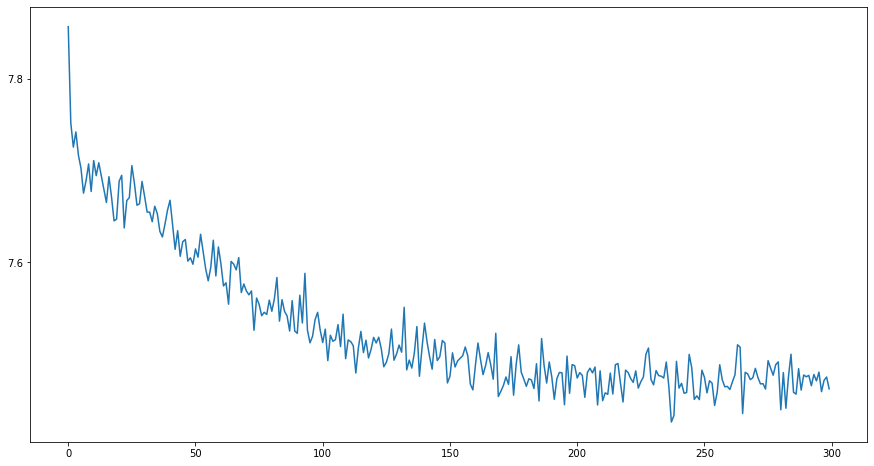

In [21]:
for iter in range(1, 30001):

    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder1, decoder1, encoder_optimizer, decoder_optimizer, criterion)

    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 100
        print_loss_total = 0
        print('iteration - %d loss - %.4f' % (iter, print_loss_avg))

    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

In [22]:
def evaluate(encoder, decoder, sentence):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]])  
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [23]:
for i in range(10):
        
        pair = random.choice(pairs)
        
        print('>', pair[0])
        print('=', pair[1])
        
        output_words = evaluate(encoder1, decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        
        print('<', output_sentence)
        print('')

> du machst es wahrscheinlich falsch .
= you re probably doing it wrong .
< you you you you where where bit godmother theater walk

> sie ist seine wahre mutter .
= she is his real mother .
< he he he he great teenager place water biased godmother

> ich lerne japanisch .
= i am learning japanese .
< i i i farmer farmer farmer godmother theater walk smoker

> ich bin polizist .
= i m a police officer .
< i i i farmer farmer farmer godmother theater walk smoker

> ich rechne mit dir .
= i m counting on you .
< i i i farmer farmer farmer godmother theater walk smoker

> ich bin kein zauberer .
= i m not a magician .
< i i i farmer farmer farmer godmother theater walk smoker

> tut mir leid wegen neulich !
= i m sorry about the other day .
< i i i farmer farmer farmer godmother theater walk smoker

> das mit tom tut mir wirklich leid .
= i m really sorry about tom .
< i i i farmer farmer farmer godmother theater walk smoker

> sie ist ungefahr in deinem alter .
= she is about your age .
<

In [24]:
input_sentence = 'es tut mir sehr leid'

In [25]:
output_words = evaluate(encoder1, decoder1, input_sentence)

In [26]:
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i i i farmer farmer farmer godmother theater walk smoker
